In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [3]:
df=pd.read_csv('../data/train.csv')

In [4]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [7]:
df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [8]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## The survival rate is calculated by dividing the number of passengers who survived by the total number of passengers.
## The following hypothesis was tested:
 Is the survival rate affected by the number of passengers in the group to which the passengers belong? The group may be derived from the PassengerId.
## Is the survival rate affected by the number of passengers in the cabin in which the passenger is travelling?
## Should we add a column for total expenditures to the list of columns for different expenses spent by a passenger? Is the survival rate affected by the overall amount spent?
## Then, we build a function that will take a dataframe and a column name as input.
##  The funnel will give as output the survival rate for the different possible values of the column. Writing this function will ensure we do not write the code to calculate survival rate multiple times

In [9]:
def survival_rate(df1,feature):
    group_count=df1[[feature,'Transported']].groupby(feature).count().rename(columns={'Transported':'Passengers'})
    group_survived=df1[[feature,'Transported']].groupby(feature).sum().rename(columns={'Transported':'survived'})
    final_df=group_count.merge(group_survived,how='left',right_index=True,left_index=True)
    final_df['survival_rate']=final_df['survived']/final_df['Passengers']
    final_df.drop(['Passengers','survived'],axis=1,inplace=True)
    return final_df

<AxesSubplot: xlabel='CryoSleep', ylabel='survival_rate'>

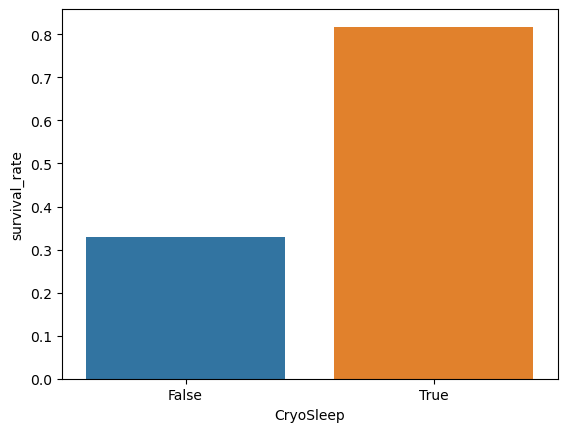

In [10]:
group_survival_rate=survival_rate(df,'CryoSleep')
group_survival_rate.reset_index(inplace=True)
sns.barplot(group_survival_rate,x='CryoSleep',y='survival_rate')

### from this plot we can see that people who were in CryoSleep had more chances for surviving than people who were not.

/var/folders/cn/r_mvyq893c357lflld6x0pvw0000gn/T/ipykernel_50057/4267768855.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df['Group']=df['PassengerId'].str.split('_',1,expand=True)[0].astype(int)


<AxesSubplot: xlabel='Passenger_in_group', ylabel='survival_rate'>

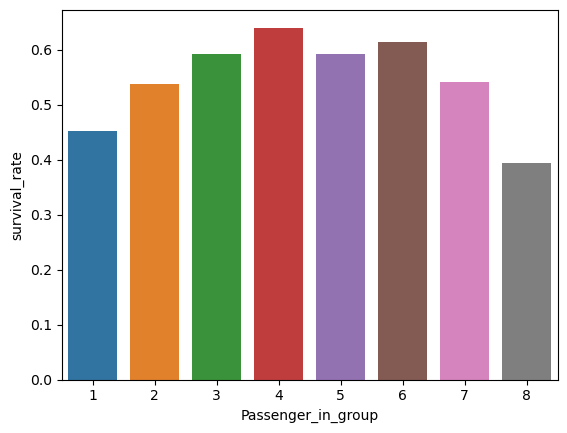

In [11]:
df['Group']=df['PassengerId'].str.split('_',1,expand=True)[0].astype(int)
group_wise=df[['Group','PassengerId']].groupby(['Group']).count().rename(columns={"PassengerId":"Passenger_in_group"})
df=pd.merge(df,group_wise,how="left",left_on="Group",right_index=True)
group_strength_survival_rate=survival_rate(df,'Passenger_in_group')
group_strength_survival_rate.reset_index(inplace=True)
group_strength_survival_rate
sns.barplot(data=group_strength_survival_rate,x="Passenger_in_group",y="survival_rate")

### from this plot we can see that from 1 to 4 groups survival rate increases after that it decreases for more people in a group.

<AxesSubplot: xlabel='passenger_cabin', ylabel='survival_rate'>

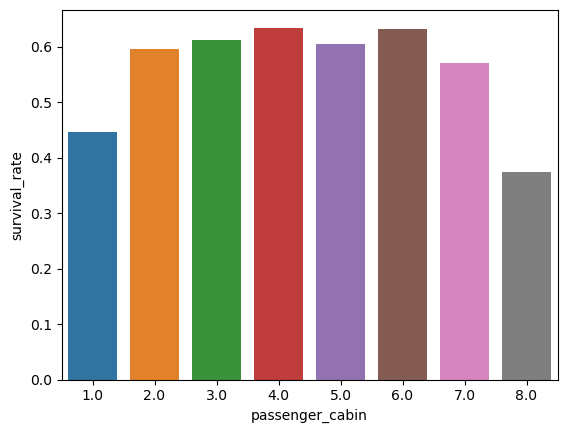

In [12]:
groupwise=df[['Cabin','PassengerId']].groupby('Cabin').count().rename(columns={'PassengerId':'passenger_cabin'})
df=pd.merge(df,groupwise,how='left',left_on='Cabin',right_index=True)
group_survival=survival_rate(df,'passenger_cabin')
group_survival.reset_index(inplace=True)
sns.barplot(data=group_survival,x="passenger_cabin",y="survival_rate")

In [13]:
df['total_spend']=df[['RoomService','FoodCourt','VRDeck','Spa','ShoppingMall']].sum(axis=1)
labels=['0-10000','10001-20000','20001-30000','30001-40000']
binss=[0, 10000, 20000, 30000, 40000]
df['cut_total_spend']=pd.cut(df['total_spend'],labels=labels,bins=binss)
df[['cut_total_spend','total_spend']]

,cut_total_spend,total_spend
0,NaN,0.0
1,0-10000,736.0
2,10001-20000,10383.0
3,0-10000,5176.0
4,0-10000,1091.0
...,...,...
8688,0-10000,8536.0
8689,NaN,0.0
8690,0-10000,1873.0
8691,0-10000,4637.0


<AxesSubplot: xlabel='cut_total_spend', ylabel='survival_rate'>

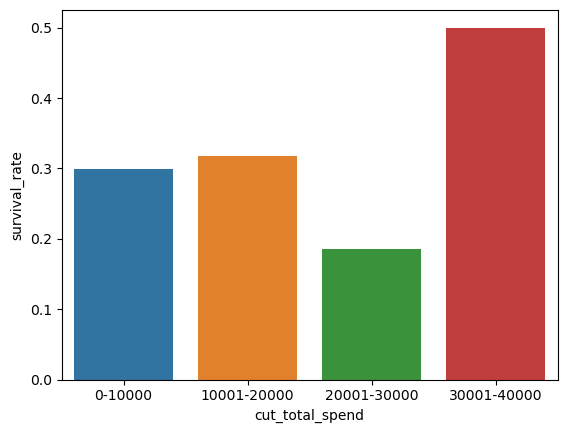

In [14]:
total_spend_survival=survival_rate(df[df['CryoSleep']==False],'cut_total_spend')
total_spend_survival.reset_index(inplace=True)
sns.barplot(data=total_spend_survival,x="cut_total_spend",y="survival_rate")

### from this plot we can see that people who spent more have more survival rate.

<AxesSubplot: xlabel='deck', ylabel='survival_rate'>

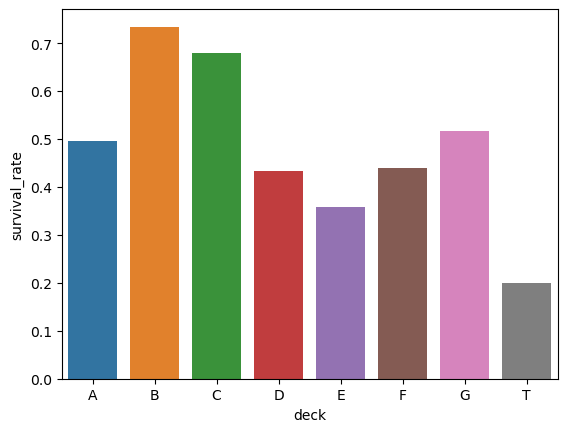

In [15]:
df['deck']=df['Cabin'].str.split('/', expand=True)[0]
deck=survival_rate(df,'deck')
deck.reset_index(inplace=True)
sns.barplot(data=deck,x="deck",y="survival_rate")

### The Survival Rate of the passengers in different cabins differs significantly. In order of highest to lowest, it is as following
### B>C>G>A>F>D>E>T

<AxesSubplot: xlabel='side', ylabel='survival_rate'>

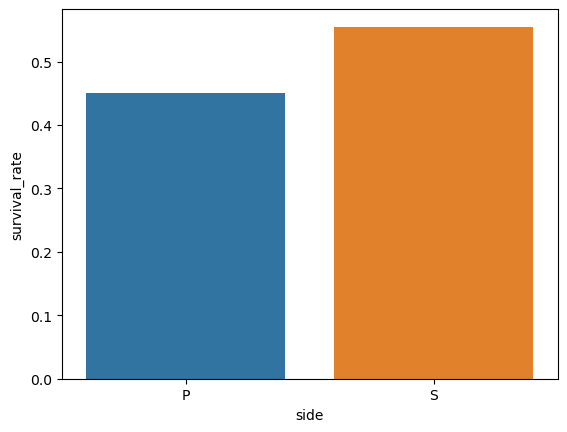

In [16]:
df['side']=df['Cabin'].str.split('/', expand=True)[2]
side=survival_rate(df,'side')
side.reset_index(inplace=True)
sns.barplot(data=side,x="side",y="survival_rate")

### The Survival Rate of passengers on the Starboard side is higher than those on Port side.

In [17]:
X=pd.read_csv('../data/train.csv')
X_test=pd.read_csv('../data/test.csv')

In [18]:
X.dropna(subset=['Transported'],axis=0,inplace=True)
x=X.drop('Transported',axis=1)
y=X['Transported']

In [19]:
X_train,X_valid,y_train,y_valid=train_test_split(x,y,test_size=0.3,random_state=101)

In [20]:
num_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in X_train.columns if X_train[col].nunique() < 10 and X_train[col].dtype == 'object']


In [21]:
my_cols=num_cols+cat_cols
X_train=X_train[my_cols].copy()
X_valid=X_valid[my_cols].copy()
X_test=X_test[my_cols].copy()

In [22]:
num_transformer=SimpleImputer(strategy='constant')
cat_transformer=Pipeline([('simple',SimpleImputer(strategy='most_frequent')),('onehot',OneHotEncoder(handle_unknown='ignore'))])

In [23]:
column_transformer=ColumnTransformer(transformers=[('num',num_transformer,num_cols),('cols',cat_transformer,cat_cols)])

In [24]:
from xgboost import XGBClassifier

In [25]:
model=XGBClassifier(n_estimators=100,learning_rate=0.05)

In [26]:
pipe=Pipeline(steps=[('preprocessor',column_transformer),('model',model)])

In [27]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('cols',
                                                  Pipeline(steps=[('simple',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP'])])),
                (...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.05,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, ...))])

In [28]:
predictions=pipe.predict(X_valid)

In [29]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay

In [30]:
print(classification_report(y_valid,predictions))

              precision    recall  f1-score   support

       False       0.82      0.75      0.79      1299
        True       0.77      0.84      0.80      1309

    accuracy                           0.80      2608
   macro avg       0.80      0.80      0.80      2608
weighted avg       0.80      0.80      0.80      2608



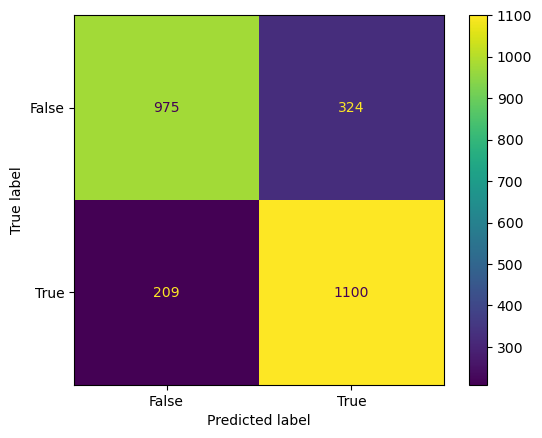

In [31]:
ConfusionMatrixDisplay.from_predictions(y_valid,predictions)

In [32]:
test_predictions=pipe.predict(X_test)

In [33]:
test_predictions

array([1, 0, 1, ..., 1, 1, 1])

In [40]:
output = pd.read_csv('../data/sample_submission.csv')
output['Transported']=test_predictions